## Importing Relevant Libraries

In [48]:
#import openai
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import snowballstemmer
import gensim

from sklearn.utils import shuffle

import re
import nltk
nltk.download('stopwords')
import time
import warnings
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import LancasterStemmer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM

from sklearn.linear_model import LogisticRegression
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import keras
from keras.models import Sequential, Model
from keras import layers
from keras.layers import Dense, Dropout, Input, Embedding

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading the csv file

In [49]:
# loading the csv to a dataframe
df = pd.read_csv("self_driving_final.csv", engine='python', encoding='latin-1', on_bad_lines='warn')
print(df.shape)

# Dropping the Date column
df = df.drop(labels=['Date'], axis=1)
df.head(5)

(78405, 4)


,Tweet_Id,Tweet,Sentiments
0,1630714267824451584,@NicksKorner @WholeMarsBlog ð. Actually For...,Positive
1,1630705984443129858,Port Authority to Host Second Platooning Demon...,Positive
2,1630704524611420165,Giving YOLOv8 a Second Look (Part 1) https://t...,Neutral
3,1630702418345197570,This over autonomous vehicles ð,Positive
4,1630702317480583168,Senior Engineer - Suspension System Software E...,Positive


## Data Preprocessing

The code below returns the count of each unique value in the 'Sentiments' column of the dataframe df.

In [50]:
df.Sentiments.value_counts()

Positive    52245
Neutral     16860
Negative     9300
Name: Sentiments, dtype: int64

The categories in the LSTM models are just two. categories  = ['Negative','Positive']. Therefore, we have to filter out the neutral category.

In [51]:
df = df[df['Sentiments'] != 'Neutral']
df.Sentiments.value_counts()

Positive    52245
Negative     9300
Name: Sentiments, dtype: int64

In [52]:
# # Shuffle the subset dataframe
df = df.sample(frac=1, random_state=0)

The code below prints the percentage of missing values for each column in the dataframe df.

In [53]:
for col in df.columns:
    pct_missing = df[col].isnull().mean()
    print(f'{col} - {pct_missing :.1%}')

Tweet_Id - 0.0%
Tweet - 0.0%
Sentiments - 0.0%


The code below returns the count of each unique value in the 'Sentiments' column of the dataframe df.

In [54]:
df['Sentiments'].value_counts()

Positive    52245
Negative     9300
Name: Sentiments, dtype: int64

In [55]:
df.head(5)

,Tweet_Id,Tweet,Sentiments
53784,547417964757012480,Google Rolls Out First Working Prototype of Se...,Positive
52280,547486427916029954,"Now that's a car, Google's first real self dri...",Positive
37642,1633617880662122498,The enabler for autonomous vehicle development...,Positive
14988,1460863733790650370,"Weâre thinking of #autonomous vehicles, #6G ...",Negative
6877,1612075120536989697,@asxyzp @Lux_Capital What do you think is the ...,Positive


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61545 entries, 53784 to 3584
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Tweet_Id    61545 non-null  int64 
 1   Tweet       61545 non-null  object
 2   Sentiments  61545 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.9+ MB


This code renames the 'Sentiments' column to 'Sentiment_str' and displays the first 3 rows of the dataframe df.

In [57]:
df = df.rename(columns={'Sentiments': 'Sentiment_str'})
df.head(3)

,Tweet_Id,Tweet,Sentiment_str
53784,547417964757012480,Google Rolls Out First Working Prototype of Se...,Positive
52280,547486427916029954,"Now that's a car, Google's first real self dri...",Positive
37642,1633617880662122498,The enabler for autonomous vehicle development...,Positive


This code below groups the dataframe df by the 'Sentiment_str' column and aggregates the 'Tweet_Id' column by counting. It then creates a pie chart to visualize the distribution between the different sentiment categories.

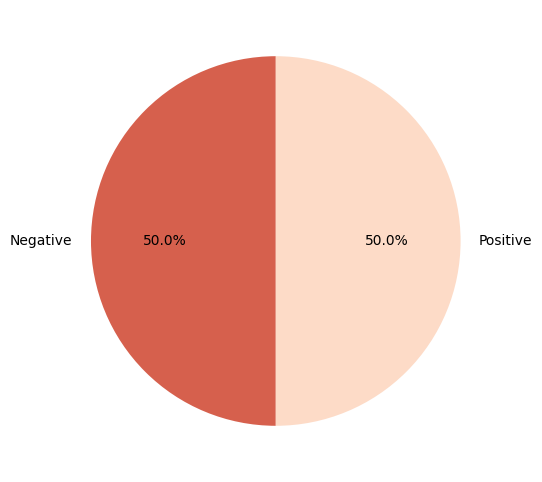

In [58]:
df_target_dist=df.groupby('Sentiment_str').agg({'Tweet_Id':'count'}).reset_index()

with sns.color_palette("RdBu",4):
    plt.figure(figsize=(14,6))
    labels = df_target_dist['Sentiment_str'].value_counts().index
    plt.pie(df_target_dist['Sentiment_str'].value_counts(), labels= labels, startangle=90, autopct='%.1f%%')
    plt.show()

The code below creates a histogram plot of the sentence length for each Tweet in the dataframe df.

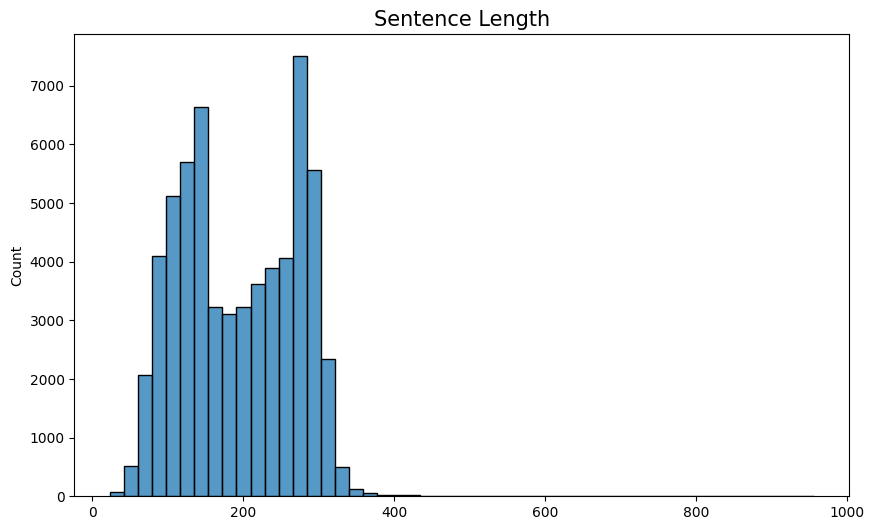

In [59]:
#plot hist of sentence length
plt.figure(figsize=(10, 6))
a=sns.histplot([len(s) for s in df.Tweet], bins=50, palette='Set1')
a.set_title("Sentence Length",fontsize=15)
plt.show()

This code creates a histogram plot of the length of words for each Tweet in the dataframe df.

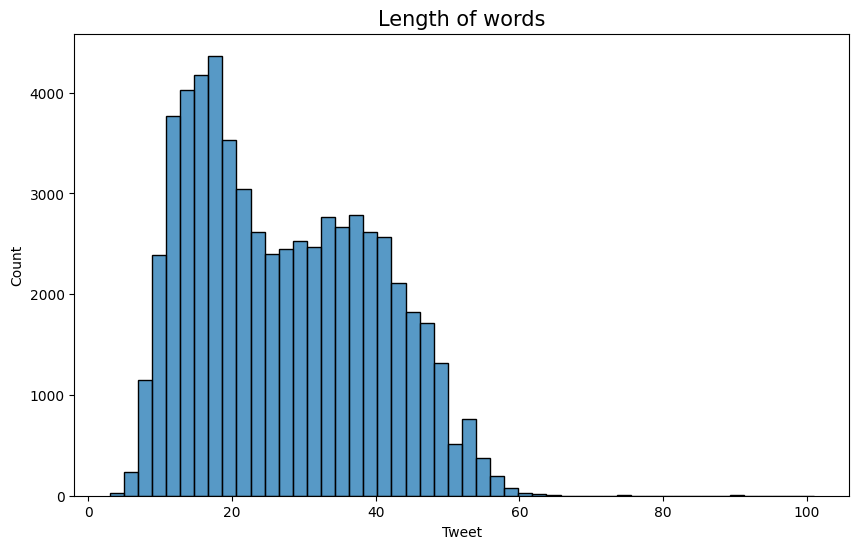

In [60]:
#plot hist of sentence length
plt.figure(figsize=(10, 6))
a=sns.histplot((df['Tweet'].str.split().map(lambda x: len(x))), bins=50, palette='Set1')
a.set_title("Length of words",fontsize=15)
plt.show()

This code creates a mapping between the different sentiment categories and numerical values, then applies the mapping to the 'Sentiment_str' column of the dataframe df and stores the result in a new column called 'Sentiment'.

Positive will be mapped with 4 and Negative will be mapped with 0

In [61]:
# define mapping function
sentiment_map = {'Positive': 1, 'Negative': 0}

# apply mapping function to sentiment column
df['Sentiment'] = df['Sentiment_str'].map(sentiment_map)

In [62]:
# #replacing
# df.Sentiments=np.where(df.Sentiment == 4, 1, 0)

The code below removes usernames, links, punctuation, special characters, and digits from the 'Tweet' column of the dataframe df.

In [63]:
def tweet_clean(tweet):
    tweet = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', tweet)
    tweet = re.sub('[^a-zA-z0-9\s]','',tweet)
    tweet = re.sub('\s+', ' ', tweet)
    tweet = re.sub(r'\\u[A-Za-z0-9\\]+',' ',tweet)
    tweet = re.sub("\d+", " ", tweet)
    tweet = tweet.lower()
    tweet = re.sub(r"@\w+\b", "", tweet)
    tweet = re.sub(r'@[A-Za-z0-9]+'," ",tweet)            #Removing the usernames
    tweet = re.sub(r'^[A-Za-z0-9.!?]+'," ",tweet)         #Removing digits and punctuations
    tweet = re.sub(r'https?://[A-Za-z0-9./]+'," ",tweet)  #Removing link
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)            #convert "#topic" to just "topic"
    #tweet = re.sub(r"\'s", " ", tweet)
    tweet = re.sub(r"\'ve", " have ", tweet)
    #tweet = re.sub(r"n't", " not ", tweet)
    tweet = re.sub(r"\'d", " would ", tweet)
    tweet = re.sub(r"\'ll", " will ", tweet)
    tweet = tweet.lower()
    tweet = tweet.strip('. .')
    tweet = tweet.replace('.',' ')
    tweet = tweet.replace('?',' ')
    tweet = tweet.replace(',',' ')
    tweet = tweet.replace('-',' ')
    tweet = re.sub('[\s]+', ' ', tweet)                   #Correct all multiple white spaces to a single white space
    tweet = tweet.replace("’", "'").replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")
    tweet = tweet.replace("won't", "will not").replace("can't", "can not")
    tweet = tweet.replace("will not", "willnot").replace("can not", "cannot")
    tweet = tweet.replace("€", " euro ")
    tweet = tweet.replace("don't", "dont").replace("do not", "dont").replace("didn't", "didnot").replace("it's", "it is").replace("did not", "didnot")
    tweet = tweet.replace(",000,000", "m").replace("n't", " not").replace("what's", "what is")
    tweet = tweet.replace(",000", "k").replace("i'm", "i am").replace("'re", " are")
    tweet = tweet.replace("he's", "he is").replace("she's", "she is").replace("'s", " own")

    return tweet

df.Tweet = df.Tweet.apply(lambda x: tweet_clean(x))

This code below uses NLTK's stopwords list to remove stopwords from the 'Tweet' column of the dataframe df.

In [64]:
stop_words=set(stopwords.words('english'))


def preprocess(Tweets, stem=False):
    tokens = []
    for token in Tweets.split():
        if token not in stop_words:
                tokens.append(token)
    return " ".join(tokens)

df.Tweet = df.Tweet.apply(lambda x: preprocess(x))

This code below removes words with fewer than 4 characters from the 'Tweet' column of the dataframe df.

In [65]:
def smallwords(Tweets):
    tokens = []
    for token in Tweets.split():
        if len(token)>4:
          tokens.append(token)
    return " ".join(tokens)

df.Tweet = df.Tweet.apply(lambda x: smallwords(x))

In [66]:
df.head(5)
df2 = df.copy()

This code splits the dataframe df into two datasets, one containing negative sentiment tweets and one containing positive sentiment tweets.

It then creates a new column called 'No_of_Words' that stores the number of words for each tweet.

In [67]:
# Spliting dataset to negatives and positives for EDA
negatives=df['Sentiment']==0
positives=df['Sentiment']==1

# Number of words for each tweet
df['No_of_Words']=[len(text.split()) for text in df['Tweet']]

This code creates a new column called 'Words' that stores the words from each tweet as a list.

It then finds the top 100 most common words in the positive sentiment tweets and stores them in a dataframe called top_pos_df and finds the top 100 most common words in the negative sentiment tweets and stores them in a dataframe called top_neg_df.

In [68]:
from collections import Counter

df['Words'] = df['Tweet'].apply(lambda x:str(x).split())

top_pos = Counter([word for text in df[positives]['Words'] for word in text])
top_pos_df=pd.DataFrame(top_pos.most_common(100),columns=['Words','Counts'])

top_neg = Counter([word for text in df[negatives]['Words'] for word in text])
top_neg_df=pd.DataFrame(top_neg.most_common(100),columns=['Words','Counts'])

This code below creates a bar plot to visualize the top 20 most common words in the positive sentiment tweets and the top 20 most common words in the negative sentiment tweets.

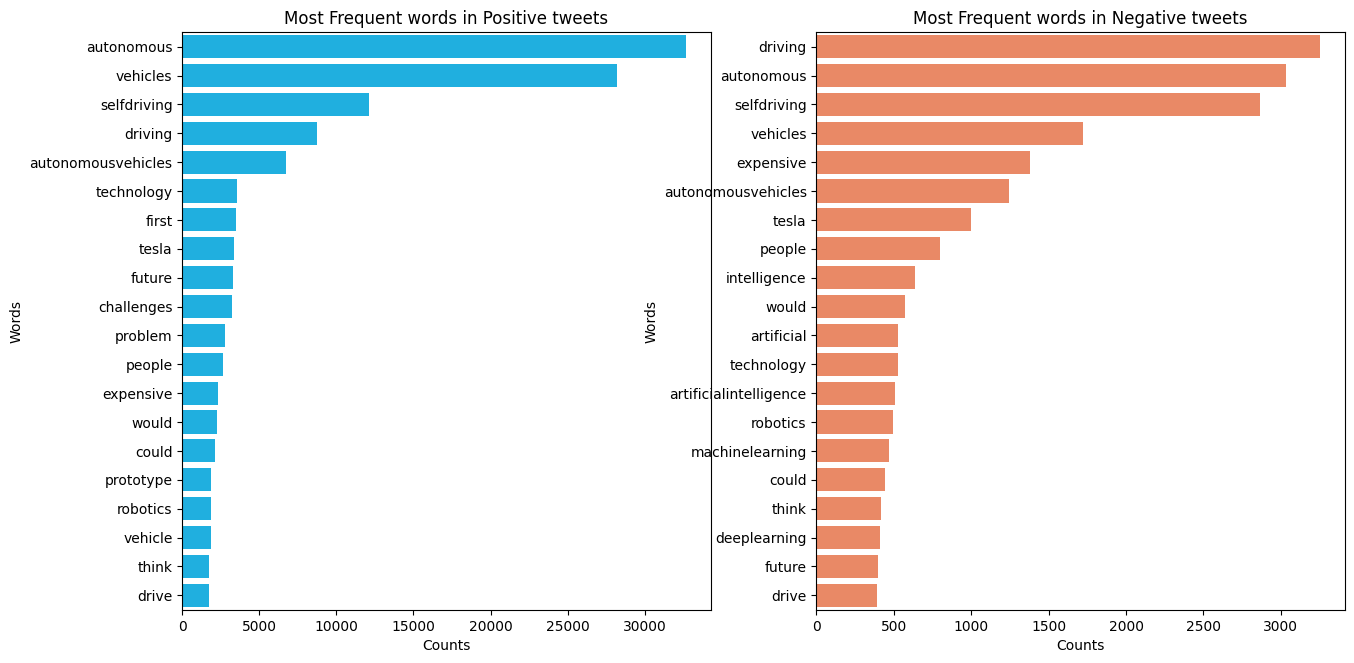

In [69]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,7.5))
sns.barplot(y='Words',x='Counts',data=top_pos_df[:20],color='deepskyblue',ax=ax[0])
sns.barplot(y='Words',x='Counts',data=top_neg_df[:20],color='coral',ax=ax[1])
ax[0].set_title("Most Frequent words in Positive tweets")
ax[1].set_title("Most Frequent words in Negative tweets")
plt.show()

This code creates two dataframes from the original dataframe 'df'. The first dataframe, 'df_pos', contains all the rows in 'df' where the Sentiment column contains the value 4.

The second dataframe, 'df_neg', contains all the rows in 'df' where the Sentiment column contains the value 0.

In [70]:
df_pos=df[df['Sentiment']==1]
df_neg=df[df['Sentiment']==0]

The code below defines two functions:
* get_top_word_bigrams
<br>This is the first function. It uses the CountVectorizer to create a bag-of-words representation of the corpus and then sorts them by frequency, returning the top n-grams if specified.

* and get_top_word_trigrams
<br>This is the second function. It does the same thing but for trigrams instead of bigrams.

In [71]:
## visualising top n-grams
def get_top_word_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_word_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

This code uses the matplotlib library to create a figure with two subplots. It then uses the get_top_word_bigrams function to find the top 20 bigrams in the positive and negative tweets.

Finally, it creates a bar plot for the top 20 bigrams in the positive and negative tweets and displays the figure.

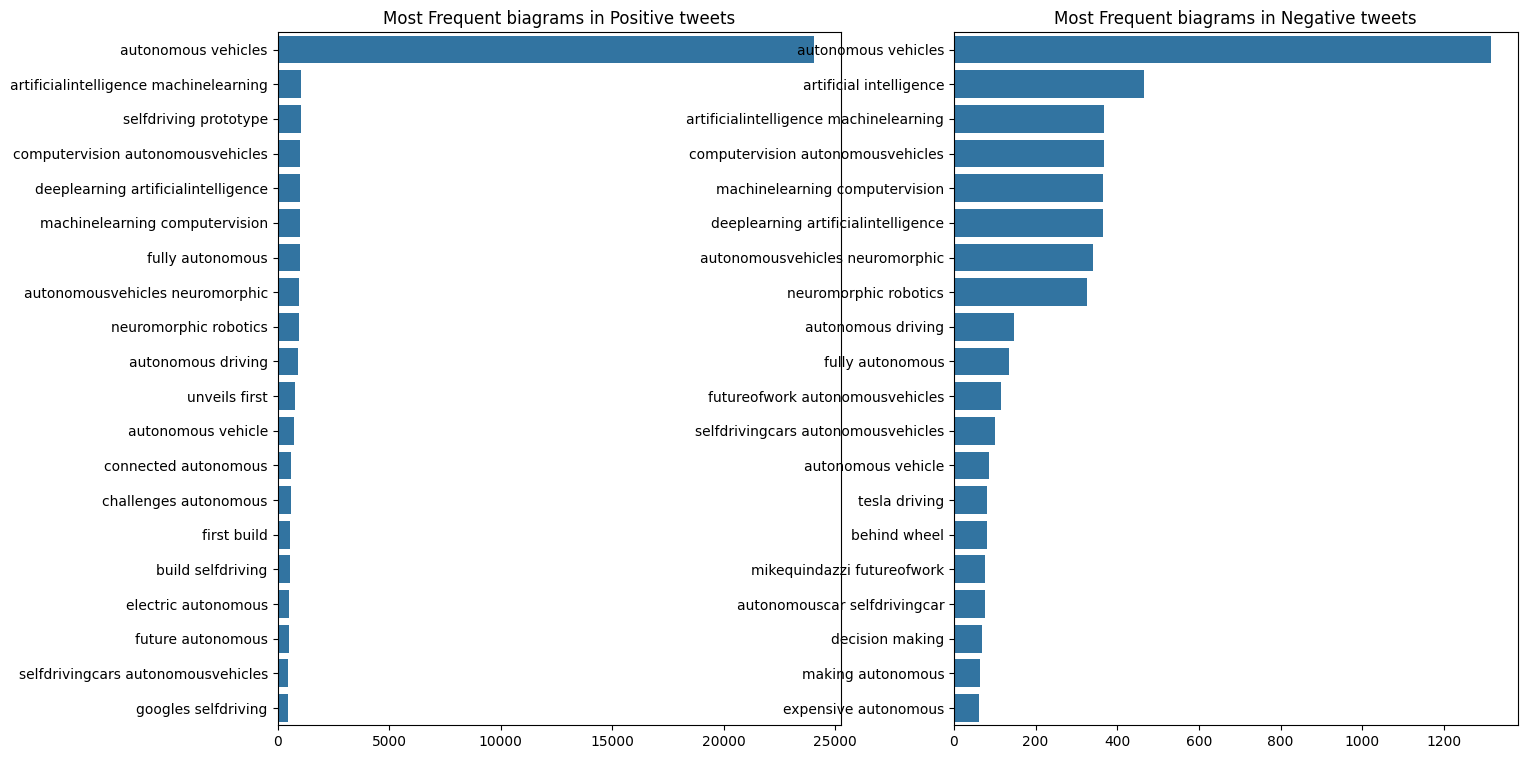

In [72]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(16,9))
top_tweet_bigrams_pos=get_top_word_bigrams(df_pos['Tweet'])[:20]
x,y=map(list,zip(*top_tweet_bigrams_pos))
sns.barplot(x=y,y=x,ax=ax[0])
top_tweet_bigrams_neg=get_top_word_bigrams(df_neg['Tweet'])[:20]
x,y=map(list,zip(*top_tweet_bigrams_neg))
sns.barplot(x=y,y=x,ax=ax[1])
ax[0].set_title("Most Frequent biagrams in Positive tweets")
ax[1].set_title("Most Frequent biagrams in Negative tweets")
plt.show()

This code uses the matplotlib library to create a figure with two subplots. It then uses the get_top_word_trigrams function to find the top 20 trigrams in the positive and negative tweets.

Finally, it creates a bar plot for the top 20 trigrams in the positive and negative tweets and displays the figure.

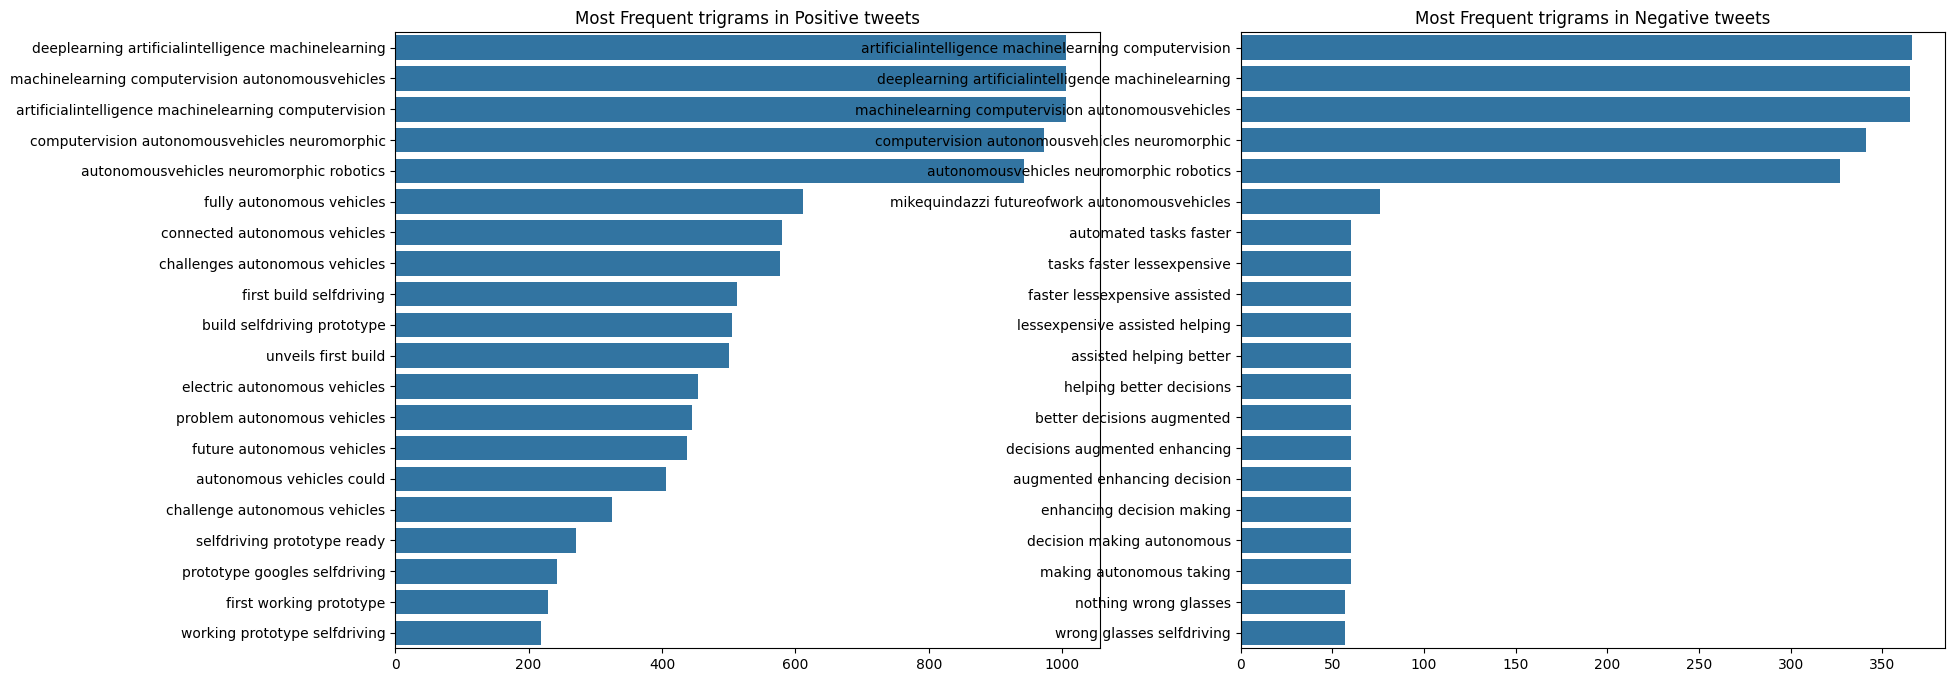

In [73]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,8))
top_tweet_trigrams_pos=get_top_word_trigrams(df_pos['Tweet'])[:20]
x,y=map(list,zip(*top_tweet_trigrams_pos))
sns.barplot(x=y,y=x,ax=ax[0])
top_tweet_trigrams_neg=get_top_word_trigrams(df_neg['Tweet'])[:20]
x,y=map(list,zip(*top_tweet_trigrams_neg))
sns.barplot(x=y,y=x,ax=ax[1])
ax[0].set_title("Most Frequent trigrams in Positive tweets")
ax[1].set_title("Most Frequent trigrams in Negative tweets")
plt.show()

### **Model (LSTM)**

The code below is a function that evaluates the performance of a given model on the test set. It first uses the model to predict the labels for the test set, then prints out the classification report for the model.

It then plots a confusion matrix that shows the performance of the model in terms of true positive, false positive, true negative and false negative counts.

In [74]:
df.head(2)

,Tweet_Id,Tweet,Sentiment_str,Sentiment,No_of_Words,Words
53784,547417964757012480,rolls first working prototype selfdriving stre...,Positive,1,7,"[rolls, first, working, prototype, selfdriving..."
52280,547486427916029954,thats googles first driving prototype google s...,Positive,1,9,"[thats, googles, first, driving, prototype, go..."


In [75]:
df['Sentiment_str'].value_counts()

Positive    52245
Negative     9300
Name: Sentiment_str, dtype: int64

#### Up Scaling Minority data

This code below is used to balance the data for a sentiment analysis. It splits the data into two data sets, a training set and a test set. It then separates the majority and minority classes in the training data, and upsamples the minority class using the resample() function from the scikit-learn library. Finally, it combines the majority class with the upsampled minority class and prints out the new class counts.

In [76]:
from sklearn.utils import resample

# Separate majority and minority classes
data_majority = df[df['Sentiment_str'] == 'Positive']
data_minority = df[df['Sentiment_str'] == 'Negative']

bias = data_minority.shape[0]/data_majority.shape[0]

# lets split train/test data first then
train = pd.concat([data_majority.sample(frac=0.8,random_state=200),
         data_minority.sample(frac=0.8,random_state=200)])

test = pd.concat([data_majority.drop(data_majority.sample(frac=0.8,random_state=200).index),
        data_minority.drop(data_minority.sample(frac=0.8,random_state=200).index)])

train = shuffle(train)
test = shuffle(test)

print('positive data in training:',(train.Sentiment_str == 'Positive').sum())
print('negative data in training:',(train.Sentiment_str == 'Negative').sum())
print('positive data in test:',(test.Sentiment_str == 'Positive').sum())
print('negative data in test:',(test.Sentiment_str == 'Negative').sum())
print("")

# Separate majority and minority classes in training data for upsampling
data_majority = train[train['Sentiment_str'] == 'Positive']
data_minority = train[train['Sentiment_str'] == 'Negative']

print("majority class before upsample:",data_majority.shape)
print("minority class before upsample:",data_minority.shape)
print("")

# Upsample minority class
data_minority_upsampled = resample(data_minority,
                                 replace=True,     # sample with replacement
                                 n_samples= data_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
data_upsampled = pd.concat([data_majority, data_minority_upsampled])

# Display new class counts
print("After upsampling\n",data_upsampled.Sentiment_str.value_counts(),sep = "")

positive data in training: 41796
negative data in training: 7440
positive data in test: 10449
negative data in test: 1860

majority class before upsample: (41796, 6)
minority class before upsample: (7440, 6)

After upsampling
Positive    41796
Negative    41796
Name: Sentiment_str, dtype: int64


This code below is used to preprocess the data for sentiment analysis. It starts by defining a max_features variable and creating a tokenizer object with the max_features parameter set to the max_features variable. The tokenizer is then trained on the whole dataset using the fit_on_texts() function. The tokenizer is then used to convert the training and test data into sequences and then padded with the pad_sequences() function. Finally, the labels for both the training and test set are converted to dummy variables.

In [77]:
max_fatures = 100000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['Tweet'].values) # training with whole data

X_train = tokenizer.texts_to_sequences(data_upsampled['Tweet'].values)
X_train = pad_sequences(X_train,maxlen=29)
y_train = pd.get_dummies(data_upsampled['Sentiment']).values
print('x_train shape:',X_train.shape)

X_test = tokenizer.texts_to_sequences(test['Tweet'].values)
X_test = pad_sequences(X_test,maxlen=29)
y_test = pd.get_dummies(test['Sentiment']).values
print("x_test shape", X_test.shape)

x_train shape: (83592, 29)
x_test shape (12309, 29)


This code below is used to create a sentiment analysis model using the Keras library. It starts by defining the embed_dim and lstm_out variables and then creating a Sequential model. The model is then created by adding an Embedding layer, a SpatialDropout1D layer, an LSTM layer, and a Dense layer with a softmax activation. Finally, the model is compiled using the categorical_crossentropy loss function and the adam optimizer.

In [78]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

embed_dim = 128
lstm_out = 192

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X_train.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 29, 128)           12800000  
                                                                 
 spatial_dropout1d_1 (Spati  (None, 29, 128)           0         
 alDropout1D)                                                    
                                                                 
 lstm_1 (LSTM)               (None, 192)               246528    
                                                                 
 dense_1 (Dense)             (None, 2)                 386       
                                                                 
Total params: 13046914 (49.77 MB)
Trainable params: 13046914 (49.77 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


This code below is used to train the sentiment analysis model created in the previous code. It starts by creating a History object and defining a batch_size variable. It then creates a class_weights dictionary that assigns weights to the two classes. Finally, the model is trained using the fit() function, with the batch_size and class_weights parameters set to the variables defined earlier, and validation data set to the test set. The callbacks parameter is also set to the History object created earlier.

In [79]:
from keras.callbacks import History
history = History()
batch_size = 128
# also adding weights
class_weights = {0: 1 ,
                1: 1.6/bias}

model.fit(X_train,
          y_train,
          epochs = 15,
          batch_size=batch_size,
          verbose = 1,
          class_weight=class_weights,
          validation_data=(X_test, y_test), callbacks=[history], steps_per_epoch=50)

Epoch 1/15
50/50 [==============================] - 46s 828ms/step - loss: 1.7787 - accuracy: 0.5097 - val_loss: 0.4056 - val_accuracy: 0.8489
Epoch 2/15
50/50 [==============================] - 41s 817ms/step - loss: 1.3470 - accuracy: 0.5312 - val_loss: 0.3160 - val_accuracy: 0.8634
Epoch 3/15
50/50 [==============================] - 42s 841ms/step - loss: 1.1030 - accuracy: 0.6356 - val_loss: 0.3173 - val_accuracy: 0.8742
Epoch 4/15
50/50 [==============================] - 37s 738ms/step - loss: 0.9765 - accuracy: 0.6855 - val_loss: 0.2995 - val_accuracy: 0.8831
Epoch 5/15
50/50 [==============================] - 42s 842ms/step - loss: 0.9162 - accuracy: 0.7198 - val_loss: 0.2954 - val_accuracy: 0.8876
Epoch 6/15
50/50 [==============================] - 41s 820ms/step - loss: 0.8392 - accuracy: 0.7588 - val_loss: 0.3178 - val_accuracy: 0.8885
Epoch 7/15
50/50 [==============================] - 37s 744ms/step - loss: 0.8582 - accuracy: 0.7522 - val_loss: 0.3419 - val_accuracy: 0.8838

This code below is used to evaluate the sentiment analysis model. It starts by predicting the labels for the test set using the model's predict() function and converting the predictions to a dataframe. It then prints out a confusion matrix and a classification report to evaluate the model's performance.

In [80]:
y_pred = np.argmax(model.predict(X_test, batch_size=batch_size), axis=1)
df_test = pd.DataFrame({'true': y_test.tolist(), 'pred':y_pred})
df_test['true'] = df_test['true'].apply(lambda x: np.argmax(x))
print("confusion matrix",confusion_matrix(df_test.true, df_test.pred))
print(classification_report(df_test.true, df_test.pred))

97/97 [==============================] - 6s 60ms/step
confusion matrix [[  796  1064]
 [  260 10189]]
              precision    recall  f1-score   support

           0       0.75      0.43      0.55      1860
           1       0.91      0.98      0.94     10449

    accuracy                           0.89     12309
   macro avg       0.83      0.70      0.74     12309
weighted avg       0.88      0.89      0.88     12309



In [81]:
print("Label balance of train is "+str(y_train.sum()/len(y_train))+". \
      For test is "+str(y_test.sum()/len(y_test)))

Label balance of train is 1.0.       For test is 1.0


In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

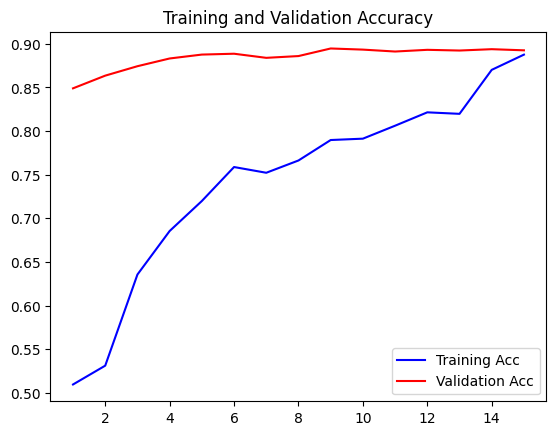

In [83]:
plt.plot(epochs, acc, label='Training Acc', color='blue')
plt.plot(epochs, val_acc, label='Validation Acc', color='red')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

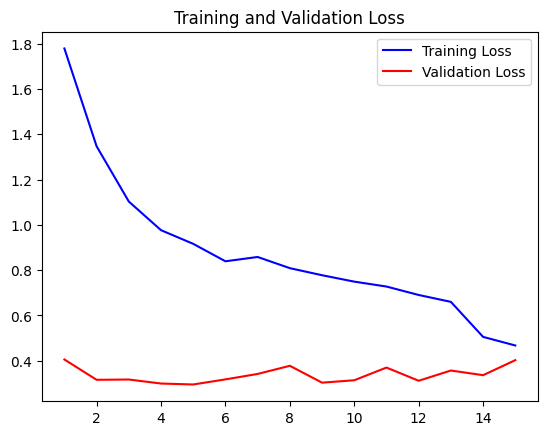

In [84]:
plt.plot(epochs, loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [85]:
y_pred = np.argmax(model.predict(X_test, batch_size=batch_size), axis=1)

df_test = pd.DataFrame({'true': np.argmax(y_test, axis=1), 'pred': y_pred})
print("confusion matrix", confusion_matrix(df_test.true, df_test.pred))
print(classification_report(df_test.true, df_test.pred))

97/97 [==============================] - 6s 60ms/step
confusion matrix [[  796  1064]
 [  260 10189]]
              precision    recall  f1-score   support

           0       0.75      0.43      0.55      1860
           1       0.91      0.98      0.94     10449

    accuracy                           0.89     12309
   macro avg       0.83      0.70      0.74     12309
weighted avg       0.88      0.89      0.88     12309



### **Logistics Regression**

This code creates a logistic regression model (lr) and fits it to the training data (X_train and Y_train). It then uses the model to make predictions on the test data (X_test).

Finally, it evaluates the model and prints out the results.

In [86]:
def model_Evaluate(model):
    try:
        # Predict values for Test dataset
        y_pred = model.predict(X_test)

        # Convert y_test from one-hot encoding to binary target form
        y_test_binary = np.argmax(y_test, axis=1)

        # Print the evaluation metrics for the dataset.
        print(classification_report(y_test_binary, y_pred))

        # Compute and plot the Confusion matrix
        cf_matrix = confusion_matrix(y_test_binary, y_pred)

    except:
        # Predict values for Test dataset
        y_pred = model.predict(X_test)

        # Print the evaluation metrics for the dataset.
        print(classification_report(y_test, y_pred))

        # Compute and plot the Confusion matrix
        cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.16      0.74      0.26      1860
           1       0.87      0.30      0.45     10449

    accuracy                           0.37     12309
   macro avg       0.51      0.52      0.36     12309
weighted avg       0.76      0.37      0.42     12309



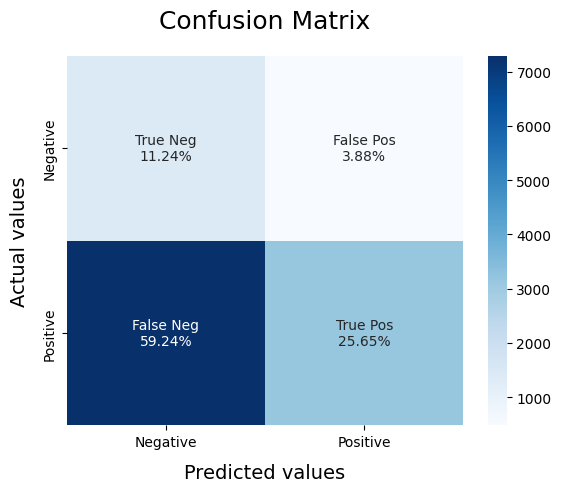

In [87]:
# For logistic regression
lr = LogisticRegression()
lr.fit(X_train, np.argmax(y_train, axis=1))
prediction_lr = lr.predict(X_test)
model_Evaluate(lr)

### **Decision Trees**

The code below creates a decision tree classifier (classifier) and fits it to the training data (X_train and y_train). It then uses the model to make predictions on the test data (X_test).

Finally, it evaluates the model and prints out the results, including the accuracy of the predictions.

Accuracy: 0.7890974084003575
              precision    recall  f1-score   support

           0       0.30      0.30      0.30      1860
           1       0.88      0.88      0.88     10449

   micro avg       0.79      0.79      0.79     12309
   macro avg       0.59      0.59      0.59     12309
weighted avg       0.79      0.79      0.79     12309
 samples avg       0.79      0.79      0.79     12309



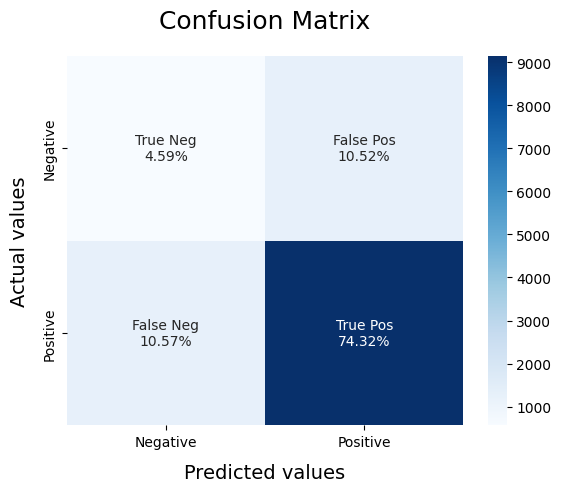

In [88]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# For decision tree classifier
classifier = DecisionTreeClassifier()
classifier = classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

model_Evaluate(classifier)

### **BERT Transformer Model**

In [89]:
# Import necessary libraries
from pylab import rcParams
from matplotlib import rc
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

In [90]:
data_upsampled.head(1)

,Tweet_Id,Tweet,Sentiment_str,Sentiment,No_of_Words,Words
59208,430516707560792064,military capitalizing driverless autonomous ve...,Positive,1,5,"[military, capitalizing, driverless, autonomou..."


In [91]:
df.head(5)
df2 = df.copy()

In [92]:
# Select 9300 positive examples
positive_df = df2[df2['Sentiment_str'] == 'Positive'].sample(n=9300, random_state=42)

# Select 9300 negative examples
negative_df = df2[df2['Sentiment_str'] == 'Negative'].sample(n=9300, random_state=42)

# Concatenate the positive and negative examples
df2 = pd.concat([positive_df, negative_df], ignore_index=True)

# # Shuffle the subset dataframe
df2 = df2.sample(frac=1, random_state=0)

This code prints out the value counts for the column "Sentiment_str" in the dataframe df2. It then drops the columns "Tweet_Id" and "Sentiment_str" from the dataframe.

df2 is created by copying the contents of df1

In [93]:
print(df2['Sentiment'].value_counts())
df2 = df2.drop(labels=['Tweet_Id', 'Sentiment_str', 'No_of_Words', 'Words'], axis=1)
df2.head(5)

1    9300
0    9300
Name: Sentiment, dtype: int64


,Tweet,Sentiment
8125,edition curiositylabptc ptreecorners manager b...,1
9619,demonstrates build autonomous without expensiv...,0
13884,metadriver tests safety without testing planet...,0
5274,story apparently teslas selfdriving video fake...,1
875,datadriven simulator multimodal sensing policy...,1


The code below loads the pretrained BERT model (checkpoint) and tokenizer from the transformers package. It then creates a model and tokenizer object from the pretrained model.

Finally, it clears the output.

In [94]:
from transformers import AutoTokenizer, TFAutoModel
from IPython.display import clear_output

checkpoint = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModel.from_pretrained(checkpoint, output_hidden_states=True)
clear_output()

The code below iterates through each column in the dataframe df2 and prints out the percentage of missing values for each column.

In [95]:
for col in df2.columns:
    pct_missing = df2[col].isnull().mean()
    print(f'{col} - {pct_missing :.1%}')

df2.dropna(inplace=True)

Tweet - 0.0%
Sentiment - 0.0%


The code below is splitting a dataframe (df2) into three disjoint sets for training, testing, and validation. The train_test_split() function from the sklearn library is used to split the dataframe into two sets, one for training and one for testing and validation.

The test_val_sequences set is then split into two separate sets, one for validation and one for testing, using the same train_test_split() function. The result is three disjoint sets of data stored in the datasets and targets dictionaries.

Finally, the code imports TensorFlow as tf, which is a Python library for deep learning.

In [96]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

sequences, test_val_sequences = train_test_split(df2, test_size=0.2,
                                             stratify=df2.Sentiment, random_state=44)
val_sequences, test_sequences = train_test_split(test_val_sequences, test_size=0.5,
                                             stratify=test_val_sequences.Sentiment, random_state=44)
dataset = {
    "TRAIN": sequences['Tweet'].values.tolist(),
    "TEST": test_sequences['Tweet'].values.tolist(),
    "VAL": val_sequences['Tweet'].values.tolist()
}
targets = {
    "TRAIN": sequences['Sentiment'].values.tolist(),
    "TEST": test_sequences['Sentiment'].values.tolist(),
    "VAL": val_sequences['Sentiment'].values.tolist()
}

The code below is defining a function called tokenization. This function takes two arguments, data and kwargs. The tokenizer function is then called, which takes in the data argument, plus several keyword arguments (kwargs).

The keyword arguments are padding, max_length, and truncation. The tokenizer function returns a tensor which is stored in the return_tensors variable.

In [97]:
def tokenization(data, **kwargs):
    return tokenizer(data,
                   padding=kwargs.get('padding','longest'),
                   max_length=kwargs.get('max_length',54),
                   truncation=True,
                   return_tensors="tf")

This code is defining a function called get_model. This function takes in a keyword argument (kwargs) and sets the max_seq_length variable to the value of the max_seq_length keyword argument or 53 if the keyword argument is not provided.

It then creates Input layers for input_ids and attention_mask and uses the model function to create a Transformer layer. The pooler_output of the Transformer is then used to create a Dense layer with 128 neurons and a Dropout layer with a dropout rate of 0.2.

Finally, an output layer is created with 1 neuron and a sigmoid activation. The model is then compiled using an Adam optimizer, a binary cross-entropy loss, and accuracy as the metric. The new_model is then returned.

In [98]:
def get_model(**kwargs):
    max_seq_length = kwargs.get('max_seq_length',54)

    input_ids = tf.keras.Input(shape=(max_seq_length,),dtype='int32')
    attention_mask = tf.keras.Input(shape=(max_seq_length,),dtype='int32')

    transformer = model({'input_ids':input_ids, 'attention_mask':attention_mask},
                        training=False)
    pooler_output  = transformer["pooler_output"]

    # Model Head
    h1 = tf.keras.layers.Dense(32, activation='relu')(pooler_output)
    dropout = tf.keras.layers.Dropout(0.2)(h1)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dropout)

    new_model = tf.keras.models.Model(inputs = [input_ids, attention_mask],
                                      outputs = output)
    new_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

    return new_model

This code is defining a function called test_result which takes in a model argument. It then uses the tokenization function to tokenize the dataset["TEST"] data. The model.predict() method is then used to predict the result_proba of the test data.

The result is then converted to a list and each value is changed to 1 if it is greater than 0.5 or 0 if it is less. The classification_report from the sklearn library is then used to print out the report of the result. Finally, the result_proba and result are returned.

In [99]:
from sklearn.metrics import classification_report

def test_result(model):
    test_inputs = tokenization(dataset["TEST"])
    result_proba = model.predict([test_inputs.input_ids, test_inputs.attention_mask])
    result = np.array(result_proba).ravel().tolist()
    result = [1 if x > 0.5 else 0 for x in result]
    print(classification_report(targets['TEST'], result))
    return result_proba, result

This code is creating a new model using the get_model() function and then passing it to the test_result() function. The result_before_all variable is then set to the output of the test_result() function which contains the result_proba and the result. The result_proba_before and result_before variables are then set to the respective values in the result_before_all variable.

In [100]:
new_model = get_model()
result_before_all = test_result(new_model)
result_proba_before, result_before = result_before_all[0], result_before_all[1]

59/59 [==============================] - 391s 6s/step
              precision    recall  f1-score   support

           0       0.50      0.99      0.67       930
           1       0.62      0.01      0.02       930

    accuracy                           0.50      1860
   macro avg       0.56      0.50      0.34      1860
weighted avg       0.56      0.50      0.34      1860



To potentially speed up the training process:
Use a smaller subset of the dataset for training: If the training data is very large, you can try using a smaller subset of the data to train the model. This can reduce the amount of time required to load and preprocess the data.

NB: You can increase the train subset as you fine tune. Note this is to reduce the time taken when training.

In [101]:
# Get a smaller subset of the data for tokenization
train_subset_size = 1000
train_subset = dataset['TRAIN'][:train_subset_size]

# Tokenize the smaller subset of the data
inputs_subset = tokenization(train_subset)
train_targets_subset = tf.convert_to_tensor(targets['TRAIN'][:train_subset_size])

val_inputs = tokenization(dataset['VAL'])
val_targets = tf.convert_to_tensor(targets['VAL'])

# Train the model on the smaller subset of the tokenized data
new_model.fit([inputs_subset.input_ids, inputs_subset.attention_mask],
              train_targets_subset,
              validation_data = ([val_inputs.input_ids, val_inputs.attention_mask], val_targets),
              epochs=2,
              batch_size=64)

Epoch 1/2
16/16 [==============================] - 990s 61s/step - loss: 0.6685 - accuracy: 0.6060 - val_loss: 0.5978 - val_accuracy: 0.6844
Epoch 2/2
16/16 [==============================] - 963s 62s/step - loss: 0.5514 - accuracy: 0.7160 - val_loss: 0.5686 - val_accuracy: 0.7097


In [102]:
result_proba_after, result_after = test_result(new_model)

59/59 [==============================] - 344s 6s/step
              precision    recall  f1-score   support

           0       0.70      0.73      0.72       930
           1       0.72      0.69      0.71       930

    accuracy                           0.71      1860
   macro avg       0.71      0.71      0.71      1860
weighted avg       0.71      0.71      0.71      1860



In [106]:
import pandas as pd
import random
from collections import Counter


test_data = pd.read_csv('self_driving_final.csv', encoding='latin-1')


sentiment_counts = Counter(test_data['Sentiments'])


actual_sentiments = test_data['Sentiments'].tolist()
num_iterations = 1000
accuracies = []


for _ in range(num_iterations):
    predicted_sentiments = []

    for _ in range(len(test_data)):

        sentiments = random.choices(list(sentiment_counts.keys()), list(sentiment_counts.values()))[0]
        predicted_sentiments.append(sentiments)


    correct_predictions = sum(1 for pred, actual in zip(predicted_sentiments, actual_sentiments) if pred == actual)
    accuracy = correct_predictions / len(predicted_sentiments)
    accuracies.append(accuracy)


average_accuracy = sum(accuracies) / num_iterations


print("Average Accuracy:", average_accuracy)


Average Accuracy: 0.5042943307187043


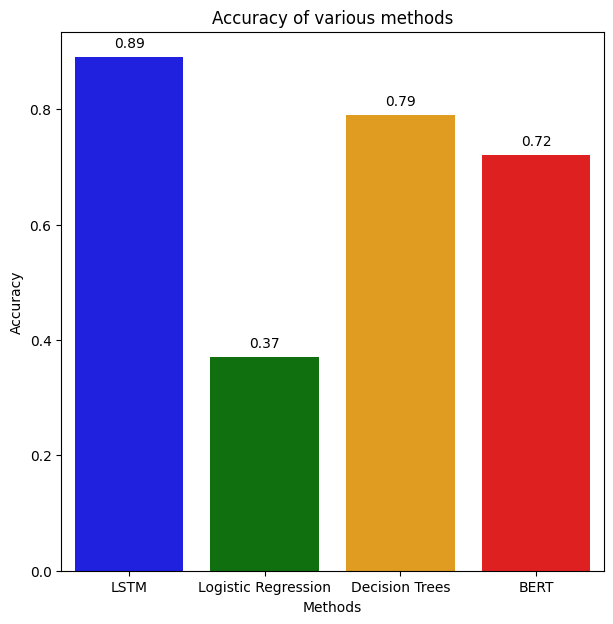

In [108]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

d = {'Methods': ['LSTM', 'Logistic Regression', 'Decision Trees', 'BERT'], 'Accuracy': [0.89, 0.37, 0.79, 0.72]}

dfc = pd.DataFrame(data=d)

# Specify custom colors for each bar
colors = ['blue', 'green', 'orange', 'red']

plt.figure(figsize=(7, 7))
ax = sns.barplot(x='Methods', y='Accuracy', data=dfc, palette=colors, errwidth=0)

# Manually add labels above the bars
for p, label in zip(ax.patches, dfc['Accuracy']):
    ax.annotate(f'{label:.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Accuracy of various methods')
plt.show()
